In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/Users/Shane/Downloads/PortfolioProjects/RFM_Model_In_Python/RFM_Data.csv', encoding= 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
df['Formatted_Date'] = pd.to_datetime(df['InvoiceDate']).dt.date
max(df['Formatted_Date'])

datetime.date(2011, 12, 9)

In [56]:
df['Total'] = df['Quantity']*df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Formatted_Date,Total,date_diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01,15.30,373
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01,20.34,373
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01,22.00,373
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01,20.34,373
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01,20.34,373


In [67]:
last_date = datetime.date(2011, 12, 9)
df['date_diff'] = (last_date - df['Formatted_Date']).dt.days
# rfm_scores 
rfm_scores = df.groupby('CustomerID').agg({'date_diff': 'max' , 'InvoiceNo':'count', 'Total':'sum'}).rename(columns=
                            {'date_diff':'Recency', 'InvoiceNo':'Frequency', 'Total':'Monetary'})
rfm_scores

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,2,0.00
12347.0,367,182,4310.00
12348.0,358,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18280.0,277,10,180.60
18281.0,180,7,80.82
18282.0,126,13,176.60


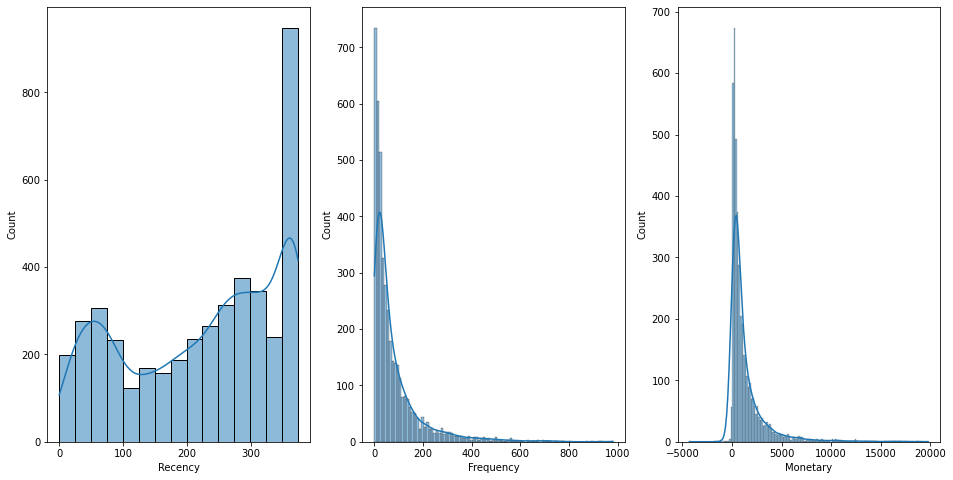

In [68]:
# RFM distribution plots
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
sns.histplot(rfm_scores['Recency'], kde=True, ax=ax[0])
sns.histplot(rfm_scores['Frequency'][rfm_scores['Frequency'] < 1000], kde=True, ax=ax[1])
sns.histplot(rfm_scores['Monetary'][rfm_scores['Monetary'] < 20000], kde=True, ax=ax[2])
plt.show()

In [71]:
# Divide the RFM groups into 3 groups by 33th and 66th quartile
# score 1 for closer recency, higer frequency and greater monetary
quartiles = rfm_scores.quantile([0.33, 0.66], axis=0)
quartiles


,Recency,Frequency,Monetary
0.33,172.0,23.0,369.2602
0.66,304.0,72.0,1119.7652


In [72]:
rfm_scores['R_score'] = np.where(rfm_scores['Recency'] < quartiles['Recency'].iloc[0], 1, (np.where(rfm_scores['Recency'] > quartiles['Recency'].iloc[1], 3, 2)))
rfm_scores['F_score'] = np.where(rfm_scores['Frequency'] > quartiles['Frequency'].iloc[1], 1, (np.where(rfm_scores['Frequency'] < quartiles['Frequency'].iloc[0], 3, 2)))
rfm_scores['M_score'] = np.where(rfm_scores['Monetary'] > quartiles['Monetary'].iloc[1], 1, (np.where(rfm_scores['Monetary'] < quartiles['Monetary'].iloc[0], 3, 2)))
rfm_scores['RFM_score'] = rfm_scores['R_score'] + rfm_scores['F_score'] + rfm_scores['M_score']
rfm_scores['RFM_score_group'] = rfm_scores['R_score'].astype(str) + rfm_scores['F_score'].astype(str) + rfm_scores['M_score'].astype(str)
rfm_scores

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,RFM_score_group
CustomerID,,,,,,,,
12346.0,325,2,0.00,3,3,3,9,333
12347.0,367,182,4310.00,3,1,1,5,311
12348.0,358,31,1797.24,3,2,1,6,321
12349.0,18,73,1757.55,1,1,1,3,111
12350.0,310,17,334.40,3,3,3,9,333
...,...,...,...,...,...,...,...,...
18280.0,277,10,180.60,2,3,3,8,233
18281.0,180,7,80.82,2,3,3,8,233
18282.0,126,13,176.60,1,3,3,7,133


<AxesSubplot:xlabel='RFM_score_group', ylabel='count'>

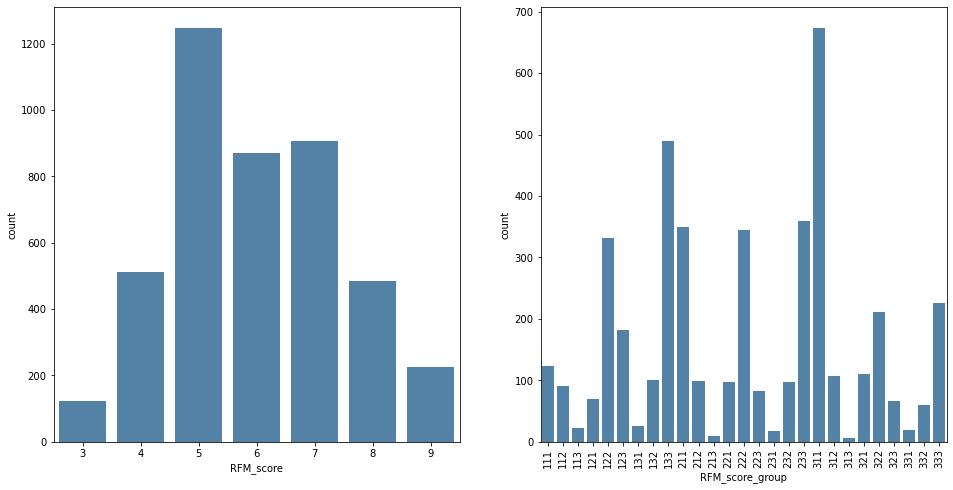

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
plt.xticks(rotation=90)

sns.countplot(x="RFM_score", data=rfm_scores, color='steelblue', ax=ax[0])
sns.countplot(x="RFM_score_group", data=rfm_scores.sort_values(by=['RFM_score_group']), color='steelblue', ax=ax[1])

In [74]:
# Refresh quartiles to get quartiles for RFM scores
quartiles = rfm_scores.quantile([0.33, 0.66], axis=0)
quartiles

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score
0.33,172.0,23.0,369.2602,2.0,1.0,1.0,5.0
0.66,304.0,72.0,1119.7652,2.0,2.0,2.0,7.0


In [75]:
# deploy loyalty labels to customer [VIP, Platinum, Gold], by 33th and 66th quartiles of rfm_score
loyalty = ['VIP', 'Platinum', 'Gold']
rfm_scores['Loyalty'] = np.where(rfm_scores['RFM_score'] < quartiles['RFM_score'].iloc[0], loyalty[0], (np.where(rfm_scores['RFM_score'] > quartiles['RFM_score'].iloc[1], loyalty[2], loyalty[1])))
rfm_scores

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,RFM_score_group,Loyalty
CustomerID,,,,,,,,,
12346.0,325,2,0.00,3,3,3,9,333,Gold
12347.0,367,182,4310.00,3,1,1,5,311,Platinum
12348.0,358,31,1797.24,3,2,1,6,321,Platinum
12349.0,18,73,1757.55,1,1,1,3,111,VIP
12350.0,310,17,334.40,3,3,3,9,333,Gold
...,...,...,...,...,...,...,...,...,...
18280.0,277,10,180.60,2,3,3,8,233,Gold
18281.0,180,7,80.82,2,3,3,8,233,Gold
18282.0,126,13,176.60,1,3,3,7,133,Platinum


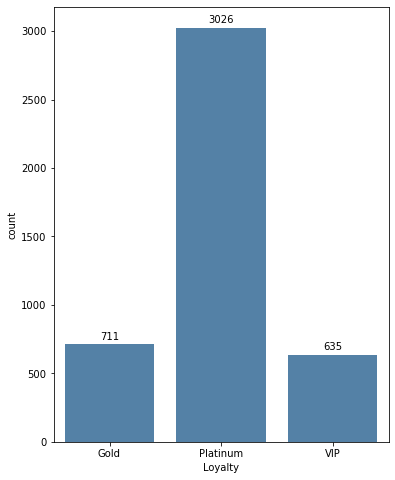

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))
sns.countplot(x="Loyalty", data=rfm_scores, color='steelblue')
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='center', xytext=(0, 8), textcoords='offset points')
    # ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 1))
plt.show()

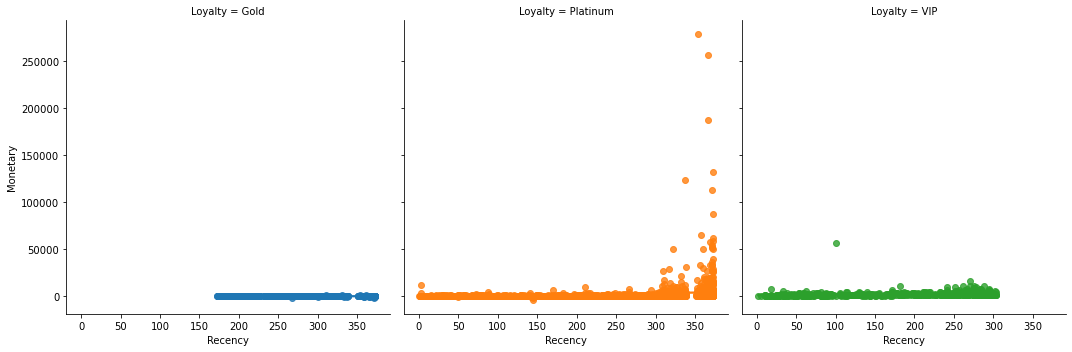

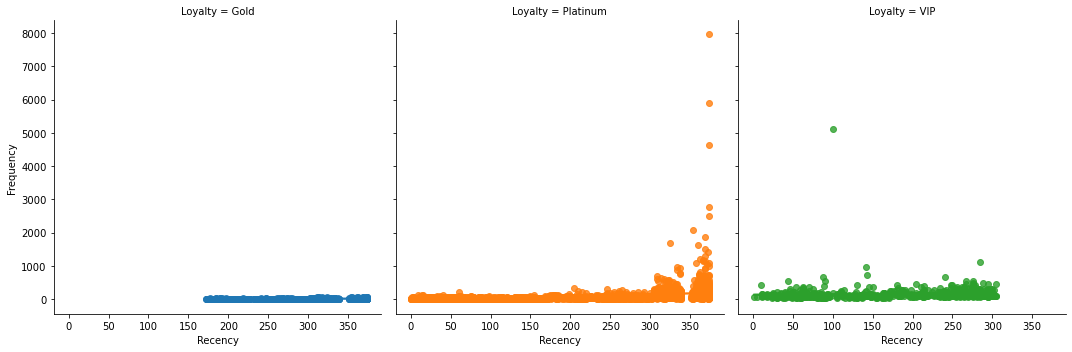

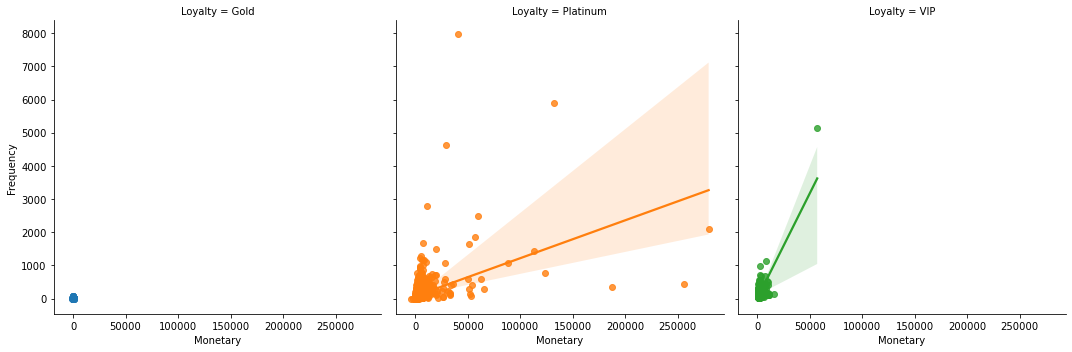

In [77]:
sns.lmplot(x='Recency', y='Monetary', data=rfm_scores, col='Loyalty', hue='Loyalty', fit_reg=True)
sns.lmplot(x='Recency', y='Frequency', data=rfm_scores, col='Loyalty', hue='Loyalty', fit_reg=True)
sns.lmplot(x='Monetary', y='Frequency', data=rfm_scores, col='Loyalty', hue='Loyalty', fit_reg=True)


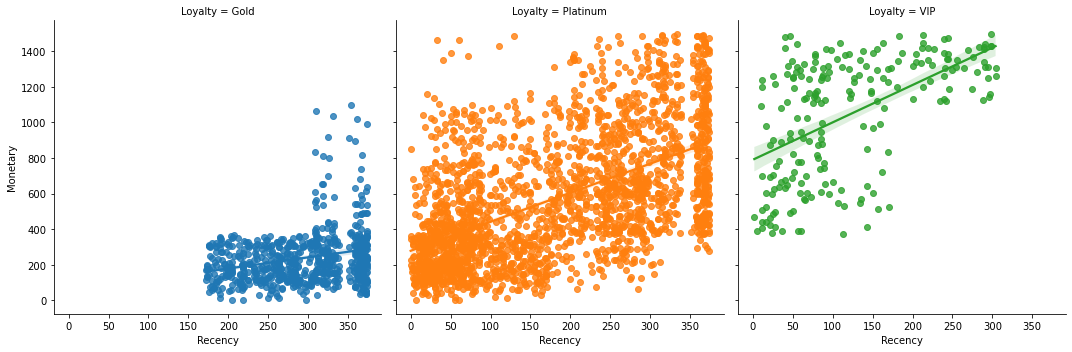

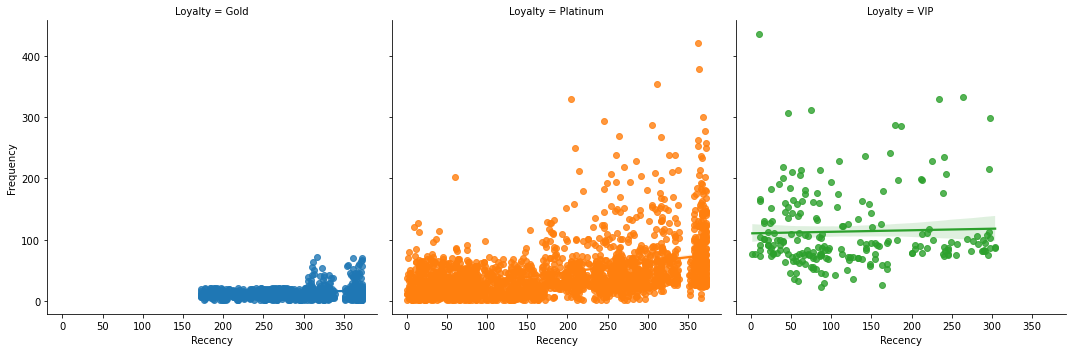

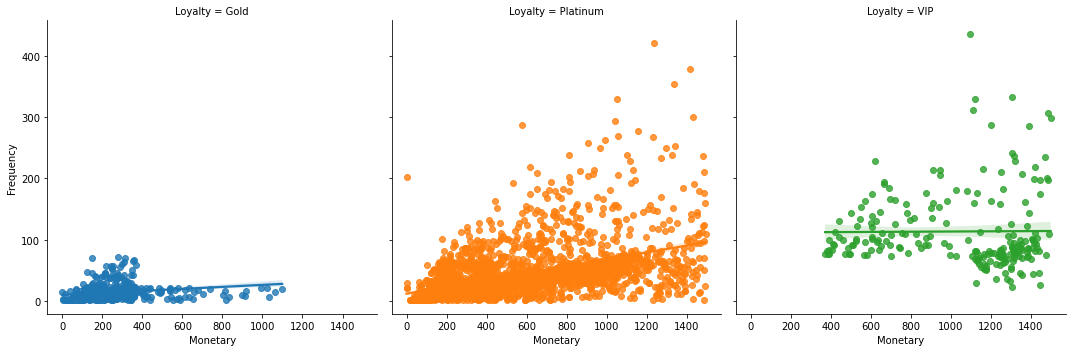

In [81]:
# hide outliers
rfm_scores_no_outliers = rfm_scores.loc[(rfm_scores['Monetary'] < 1500) & (rfm_scores['Monetary'] > 0) & (rfm_scores['Frequency'] < 500)]

sns.lmplot(x='Recency', y='Monetary', data=rfm_scores_no_outliers, col='Loyalty', hue='Loyalty', fit_reg=True)
sns.lmplot(x='Recency', y='Frequency', data=rfm_scores_no_outliers, col='Loyalty', hue='Loyalty', fit_reg=True)
sns.lmplot(x='Monetary', y='Frequency', data=rfm_scores_no_outliers, col='Loyalty', hue='Loyalty', fit_reg=True)

Summary
- Gold customers are mostly dormant customers without recent purchase in ~170 days. Their frequency and monetary values are also the least among three groups.
=> welcome-back / we-miss-you coupons to attract them to buy again

- Platinum VS VIP
- No obvious correlation between recency and monetary values for Platinum, while there is a moderately positve correlation between recenct and monetary for VIPs.
- No obvious correlation between freqency and monetary values for both Platinum and VIPs.
- Quite a lot of Platinum customers illustrated similar Frequency and Monetary values with VIPs
=> 'buy more redeem more' loyalty program to try to upgrade as many Platinum customers to Gold
- Interestingly, there is a large group of buyers with high purchasing power (high monetary values) but relatively low frequency. It can possibly be that their average order size is bigger for stocking up.
=> Better customer service & lower minimum order size for free delivery etc. for VIPs

